In [15]:
# Spam Detection Using Bayesian Probability
# ========================================

import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import nltk
import os
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dilhara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Load Dataset (SMS Spam Collection)

base_dir = os.getcwd()
data_path = os.path.join(base_dir, "data", "SMSSpamCollection")
df = pd.read_csv(data_path, sep='\t', header=None, names=['label', 'message'])

# Preview
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
# Missing value handeling
df.isna().sum()

label      0
message    0
dtype: int64

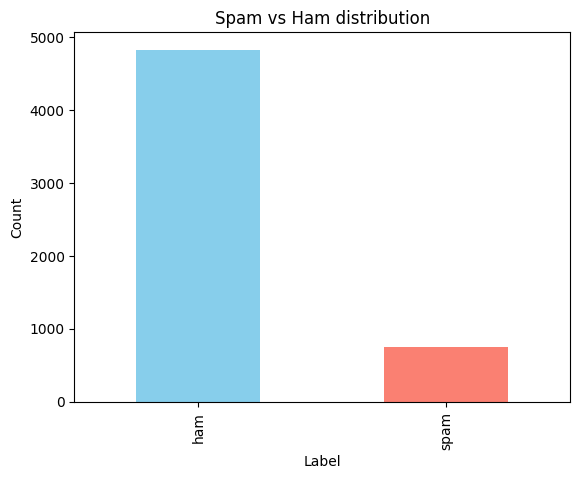

In [18]:
# Label distribution
df['label'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title("Spam vs Ham distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


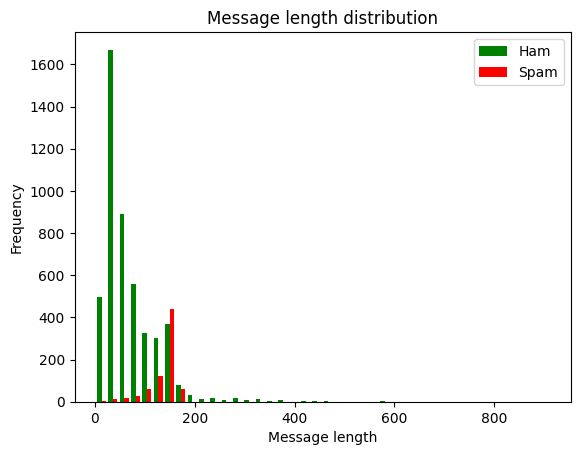

In [19]:
# 3. Basic text exploration
df['length'] = df['message'].apply(len)
plt.hist([df[df['label']=='ham']['length'], df[df['label']=='spam']['length']],
         bins=40, label=['Ham','Spam'], color=['green','red'])
plt.legend()
plt.title("Message length distribution")
plt.xlabel("Message length")
plt.ylabel("Frequency")
plt.show()

In [20]:
# Preprocessing 
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['message'].apply(clean_text)
df.head()

,label,message,length,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think goes usf lives around though


In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

=== From Scratch Naive Bayes ===
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.97      0.90      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



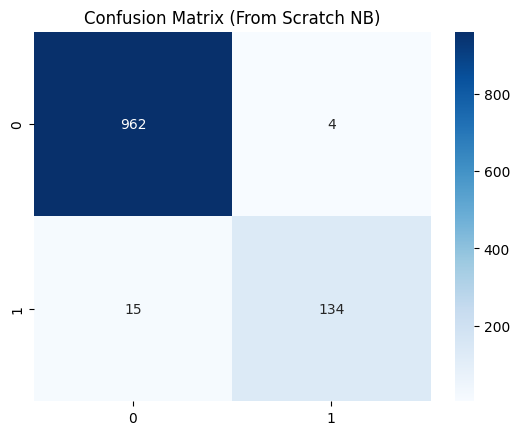

In [22]:
# 🧩 From-Scratch Multinomial Naive Bayes
class MultinomialNB_from_scratch:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.word_counts = {}
        self.class_total_words = {}
        self.vocab = set()

    def fit(self, texts, labels):
        classes = set(labels)
        N = len(labels)
        for c in classes:
            self.word_counts[c] = Counter()
            self.class_total_words[c] = 0
        class_counts = Counter(labels)
        for text, c in zip(texts, labels):
            tokens = text.split()
            self.word_counts[c].update(tokens)
            self.class_total_words[c] += len(tokens)
            self.vocab.update(tokens)
        V = len(self.vocab)
        for c in classes:
            self.class_priors[c] = class_counts[c] / N
        self.log_prob_w_given_c = {}
        for c in classes:
            denom = self.class_total_words[c] + self.alpha * V
            self.log_prob_w_given_c[c] = defaultdict(lambda: math.log(self.alpha / denom))
            for w, cnt in self.word_counts[c].items():
                self.log_prob_w_given_c[c][w] = math.log((cnt + self.alpha) / denom)

    def predict(self, texts):
        preds = []
        for text in texts:
            tokens = text.split()
            scores = {}
            for c in self.class_priors:
                score = math.log(self.class_priors[c])
                for t in tokens:
                    score += self.log_prob_w_given_c[c][t]
                scores[c] = score
            preds.append(max(scores, key=scores.get))
        return preds

# Train and evaluate
scratch_model = MultinomialNB_from_scratch(alpha=1.0)
scratch_model.fit(X_train.tolist(), y_train.tolist())
pred_scratch = scratch_model.predict(X_test.tolist())

print("=== From Scratch Naive Bayes ===")
print(classification_report(y_test, pred_scratch))
cm = confusion_matrix(y_test, pred_scratch)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (From Scratch NB)")
plt.show()


In [23]:
# Error analysis

pred_series = pd.Series(pred_scratch, index=y_test.index)

wrong = X_test[pred_series != y_test]

print("Examples of misclassified messages:\n")
for i, msg in enumerate(wrong[:5]):
    original_index = wrong.index[i]
    
    print(f"{i+1}) {msg}\n"
          f"Pred: {pred_series[original_index]} | True: {y_test[original_index]}\n")

Examples of misclassified messages:

1) freemsg hey darling 3 week word back like fun still tb ok xxx std chgs send 1 50 rcv
Pred: ham | True: spam

2) u receive msg
Pred: spam | True: ham

3) talk sexy make new friends fall love worlds discreet text dating service text vip 83110 see could meet
Pred: ham | True: spam

4) ringtoneking 84484
Pred: ham | True: spam

5) sorry missed call let talk time 07090201529
Pred: ham | True: spam

